In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
def read_data(file_path):
    ref_data_npz = np.load(file_path, allow_pickle=True)
    keys = ref_data_npz.files
    ref_data_dict = {key: ref_data_npz[key] for key in keys}
    return ref_data_dict

In [21]:
original_file_name = '02-constspeed_reduced_humanoid'
file_dir = 'neumove_models/reference_motions'
file_path = os.path.join(file_dir,f"{original_file_name}.npz")
original_data = read_data(file_path)
original_sample_rate = 500#Hz

In [4]:
print(type(original_data))

<class 'dict'>


# Change sampling rate

In [5]:
original_data_length = 0
for key in original_data.keys():
    if key != "meta_data":
        original_data_length = len(original_data[key])
        break
print(original_data_length)

449000


In [6]:
new_sample_rate = 50  # 원하는 샘플 레이트
new_length = int(original_data_length * new_sample_rate / original_sample_rate)

interpolated_data = {}

original_x = np.linspace(0, original_data_length - 1, original_data_length)
new_x = np.linspace(0, original_data_length - 1, new_length)

for key in original_data.keys():
    interpolated_data[key] = np.interp(new_x, original_x, original_data[key])
interpolated_data_length = len(interpolated_data[next(iter(interpolated_data))])
print(interpolated_data_length)

44900


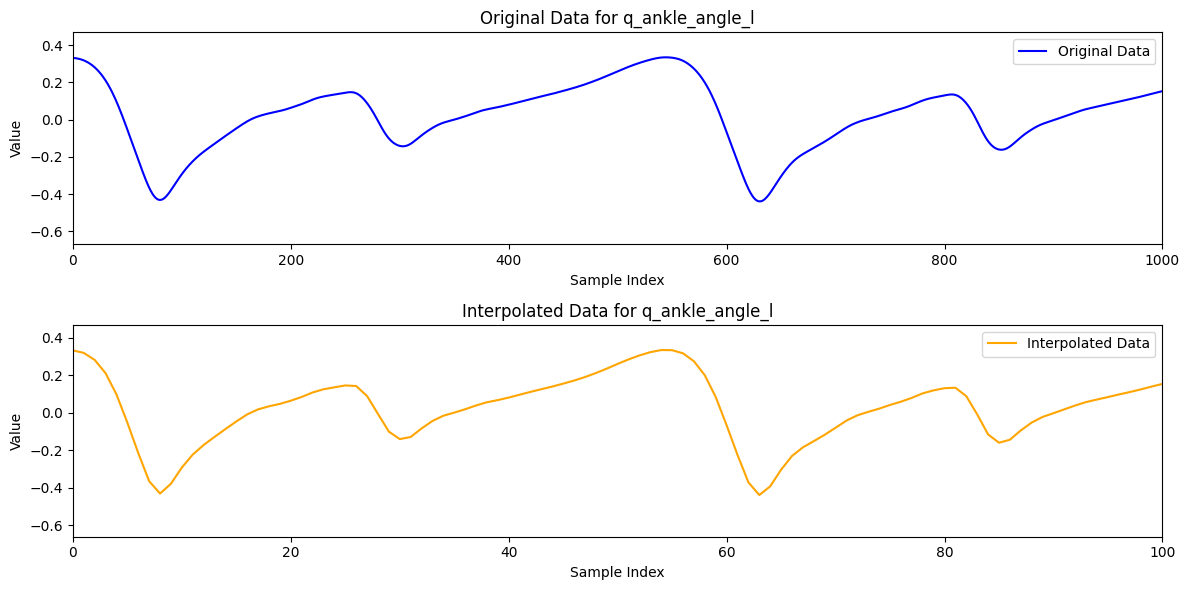

In [7]:
key = "q_ankle_angle_l"

fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 2행 1열의 서브플롯 생성
    
# 원본 데이터 플로팅
ax[0].plot(original_data[key], label='Original Data', color='blue')
ax[0].set_title(f'Original Data for {key}')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Value')
ax[0].legend()

# 보간된 데이터 플로팅
ax[1].plot(interpolated_data[key], label='Interpolated Data', color='orange')
ax[1].set_title(f'Interpolated Data for {key}')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Value')
ax[1].legend()

ax[0].set_xlim(0, 2 * original_sample_rate)
ax[1].set_xlim(0, 2 * new_sample_rate)

plt.tight_layout()
plt.show()

In [8]:
interpolated_data["meta_data"] = {
    "sample_rate": new_sample_rate,
}


# save file

In [9]:
modified_data = interpolated_data

In [51]:
modified_file_name = f"{original_file_name}_{new_sample_rate}Hz"
output_file_path = os.path.join(file_dir,f"{modified_file_name}.npz")
np.savez(output_file_path, **modified_data)
modified_data_read = read_data(output_file_path)
print(modified_data_read.keys())
modified_data_length = 0
for key in modified_data_read.keys():
    if key != "meta_data":
        modified_data_length = len(modified_data_read[key])
        break
print(modified_data_length)
print(modified_data_read["meta_data"])
print(type(modified_data_read["meta_data"]))
print(type(modified_data_read["meta_data"].item()))
print(modified_data_read["meta_data"].item()["sample_rate"])

dict_keys(['q_pelvis_tx', 'q_pelvis_tz', 'q_pelvis_ty', 'q_pelvis_tilt', 'q_pelvis_list', 'q_pelvis_rotation', 'q_hip_flexion_r', 'q_hip_adduction_r', 'q_hip_rotation_r', 'q_knee_angle_r', 'q_ankle_angle_r', 'q_subtalar_angle_r', 'q_mtp_angle_r', 'q_hip_flexion_l', 'q_hip_adduction_l', 'q_hip_rotation_l', 'q_knee_angle_l', 'q_ankle_angle_l', 'q_subtalar_angle_l', 'q_mtp_angle_l', 'q_lumbar_extension', 'q_lumbar_bending', 'q_lumbar_rotation', 'q_arm_flex_r', 'q_arm_add_r', 'q_arm_rot_r', 'q_elbow_flex_r', 'q_pro_sup_r', 'q_wrist_flex_r', 'q_wrist_dev_r', 'q_arm_flex_l', 'q_arm_add_l', 'q_arm_rot_l', 'q_elbow_flex_l', 'q_pro_sup_l', 'q_wrist_flex_l', 'q_wrist_dev_l', 'dq_pelvis_tx', 'dq_pelvis_tz', 'dq_pelvis_ty', 'dq_pelvis_tilt', 'dq_pelvis_list', 'dq_pelvis_rotation', 'dq_hip_flexion_r', 'dq_hip_adduction_r', 'dq_hip_rotation_r', 'dq_knee_angle_r', 'dq_ankle_angle_r', 'dq_subtalar_angle_r', 'dq_mtp_angle_r', 'dq_hip_flexion_l', 'dq_hip_adduction_l', 'dq_hip_rotation_l', 'dq_knee_angle

# Add Joint Anchor

In [30]:
from myosuite.utils import gym
import numpy as np
from package.config import session_config
import time

env_args_dict = {'model_path':'neumove_models/gait14dof22musc_cvt3_Right_Toeless_2D.xml',
    # env_args_dict = {'model_path':'neumove_models/gait14dof22musc_cvt3_Right_Toeless_3D.xml',
                # 'reset_type':'init',
                'target_reach_range': {
                    'pelvis': ((-.05, -.05, 0), (0.05, 0.05, 0)),
                },
                'reference_data':modified_data_read,
                }
env_args_dict.update(session_config["env_params"])
env_name = "myoLegRoughTerrainWalk2DImitationLearning-v0"

envw = gym.make(env_name) if env_args_dict==None else gym.make(env_name, **(env_args_dict))
env = envw.unwrapped
env.mujoco_render_frames = True
obs, info = env.reset()

new_datas = {
    "a_knee_angle_l":[],
    "a_knee_angle_r":[],
    "a_ankle_angle_l":[],
    "a_ankle_angle_r":[],
}

for idx in range(modified_data_length):
    print(f"\ridx:{idx}/{modified_data_length}\t\t\t", end="")
    # time.sleep(env.dt)
    # print(env.dt, env.REF_FRAME_SKIP)
    # action, _states = model.predict(obs, deterministic=True)
    # index = env.imitation_step(True,specific_index=i)
    index = env.imitation_step(True,specific_index=idx)

    body_pos = env.unwrapped.sim.data.body('pelvis').xpos.copy()

    # print(env.unwrapped.sim.data.joint('knee_angle_r').xanchor)
    new_datas["a_knee_angle_r"].append(env.unwrapped.sim.data.joint('knee_angle_r').xanchor.copy() - body_pos)
    new_datas["a_knee_angle_l"].append(env.unwrapped.sim.data.joint('knee_angle_l').xanchor.copy() - body_pos)
    new_datas["a_ankle_angle_l"].append(env.unwrapped.sim.data.joint('ankle_angle_l').xanchor.copy() - body_pos)
    new_datas["a_ankle_angle_r"].append(env.unwrapped.sim.data.joint('ankle_angle_r').xanchor.copy() - body_pos)


idx:44899/44900			

In [38]:
for k in new_datas:
    new_datas[k] = np.array(new_datas[k])
modified_data_read.update(new_datas)

In [ ]:
frame = env.unwrapped.sim.renderer.render_offscreen(camera_id=1)
plt.figure()
plt.imshow(frame)
plt.show()
env.unwrapped.dt

In [40]:
print(modified_data_read["a_knee_angle_l"])
print(np.linalg.norm(modified_data_read["a_knee_angle_l"][0]))

[[-0.2023  0.0836 -0.4418]
 [-0.2064  0.0836 -0.4402]
 [-0.2061  0.0836 -0.4403]
 ...
 [-0.0014  0.0836 -0.4677]
 [-0.0173  0.0836 -0.4698]
 [-0.0325  0.0836 -0.471 ]]
0.49299853773213587


# save again

In [35]:
modified_file_name = f"{original_file_name}_{new_sample_rate}Hz_Anchor"
output_file_path = os.path.join(file_dir,f"{modified_file_name}.npz")
np.savez(output_file_path, **modified_data_read)

# Segmentation and save average gait_data

In [4]:
original_file_name = '02-constspeed_reduced_humanoid'
file_dir = 'neumove_models/reference_motions'
file_path = os.path.join(file_dir,f"{original_file_name}.npz")
original_data = read_data(file_path)
original_sample_rate = 500#Hz

dict_keys(['q_pelvis_tx', 'q_pelvis_tz', 'q_pelvis_ty', 'q_pelvis_tilt', 'q_pelvis_list', 'q_pelvis_rotation', 'q_hip_flexion_r', 'q_hip_adduction_r', 'q_hip_rotation_r', 'q_knee_angle_r', 'q_ankle_angle_r', 'q_subtalar_angle_r', 'q_mtp_angle_r', 'q_hip_flexion_l', 'q_hip_adduction_l', 'q_hip_rotation_l', 'q_knee_angle_l', 'q_ankle_angle_l', 'q_subtalar_angle_l', 'q_mtp_angle_l', 'q_lumbar_extension', 'q_lumbar_bending', 'q_lumbar_rotation', 'q_arm_flex_r', 'q_arm_add_r', 'q_arm_rot_r', 'q_elbow_flex_r', 'q_pro_sup_r', 'q_wrist_flex_r', 'q_wrist_dev_r', 'q_arm_flex_l', 'q_arm_add_l', 'q_arm_rot_l', 'q_elbow_flex_l', 'q_pro_sup_l', 'q_wrist_flex_l', 'q_wrist_dev_l', 'dq_pelvis_tx', 'dq_pelvis_tz', 'dq_pelvis_ty', 'dq_pelvis_tilt', 'dq_pelvis_list', 'dq_pelvis_rotation', 'dq_hip_flexion_r', 'dq_hip_adduction_r', 'dq_hip_rotation_r', 'dq_knee_angle_r', 'dq_ankle_angle_r', 'dq_subtalar_angle_r', 'dq_mtp_angle_r', 'dq_hip_flexion_l', 'dq_hip_adduction_l', 'dq_hip_rotation_l', 'dq_knee_angle

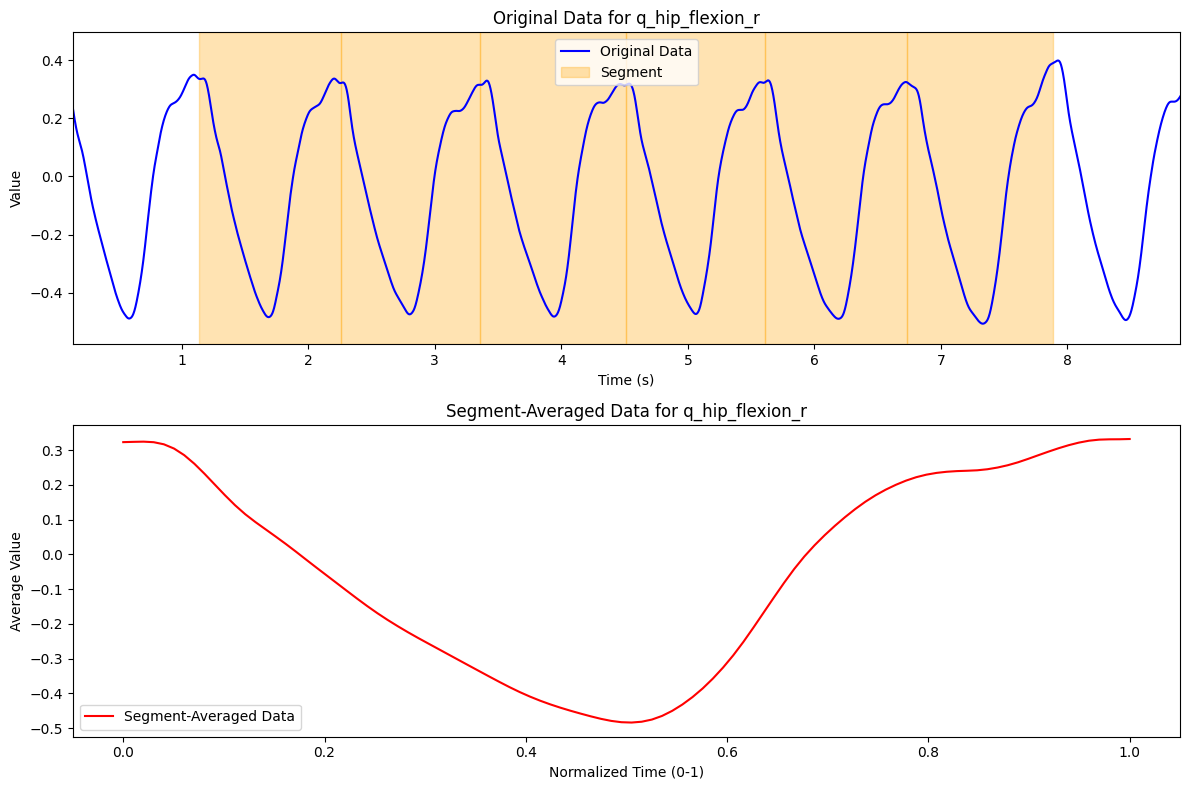

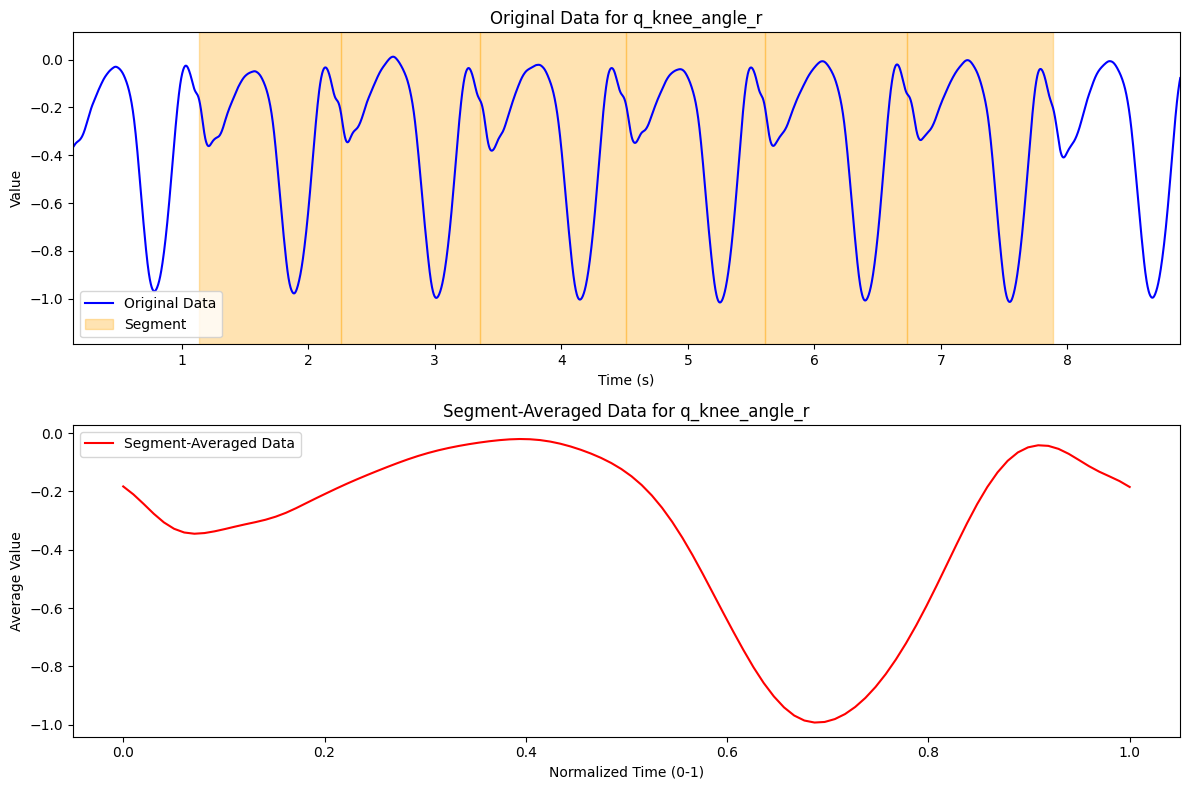

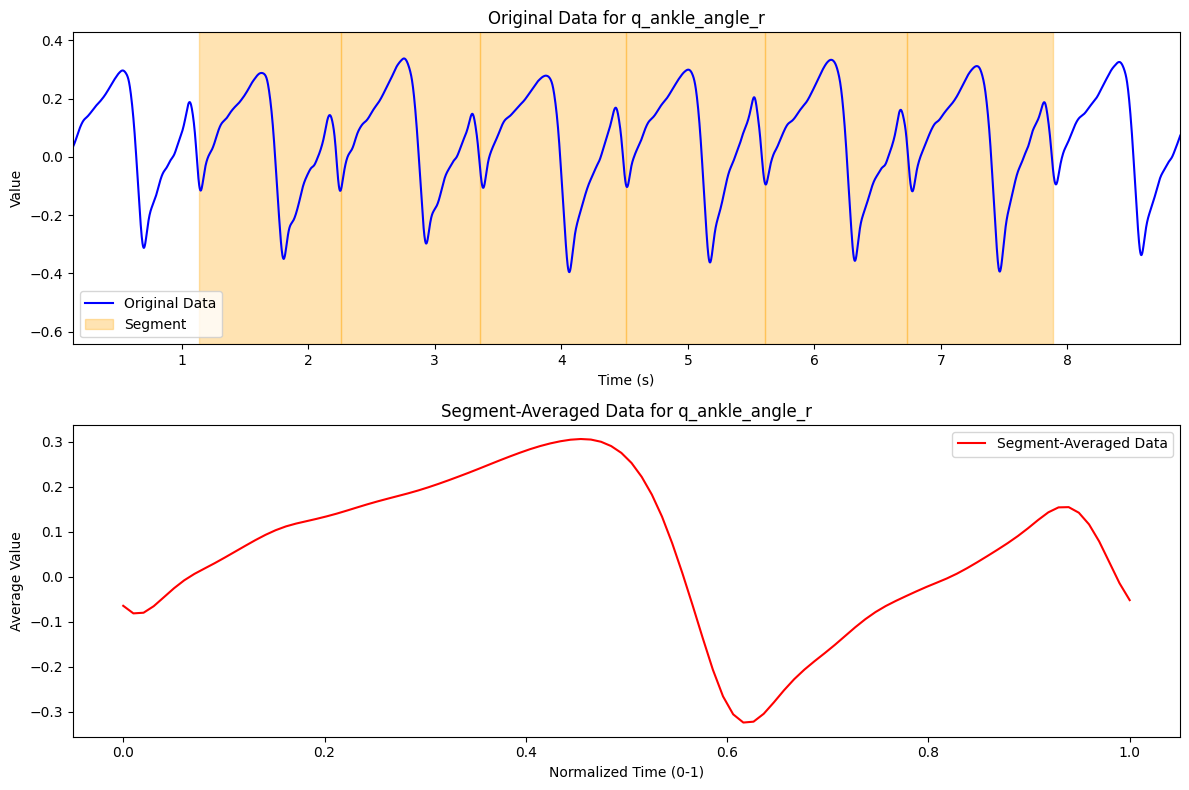

In [7]:
segments_list = [1.03,2.15,3.25,4.4,5.5,6.62,7.78]
shift = +0.11
for idx in range(len(segments_list)):
    segments_list[idx] += shift
average_data_dict = {}

average_data_dict["meta_data"] = {
    "segments_list": segments_list,
}
print(f"{original_data.keys()}")

for key in original_data.keys():
    segments = []
    segment_indices = []

    for i in range(len(segments_list) - 1):
        segment_start_idx = int(segments_list[i] * original_sample_rate)
        segment_end_idx = int(segments_list[i + 1] * original_sample_rate)
        if segment_end_idx <= len(original_data[key]):
            segment = original_data[key][segment_start_idx:segment_end_idx]
            segments.append(segment)
            segment_indices.append((segment_start_idx, segment_end_idx))

    average_data = np.zeros(100)
    x_normalized = np.linspace(0, 1, 100)

    for segment in segments:
        x_original = np.linspace(0, 1, len(segment))
        segment_interpolated = np.interp(x_normalized, x_original, segment)
        average_data += segment_interpolated

    average_data /= len(segments)
    average_data_dict[key] = average_data

keys_to_plot = ["q_hip_flexion_r","q_knee_angle_r","q_ankle_angle_r"]
for key in keys_to_plot:
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    ax[0].plot(original_data[key], label='Original Data', color='blue')
    for (start_idx, end_idx) in segment_indices:
        ax[0].axvspan(start_idx, end_idx, color='orange', alpha=0.3,
                      label='Segment' if 'Segment' not in ax[0].get_legend_handles_labels()[1] else "")
    ax[0].set_title(f'Original Data for {key}')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Value')

    tick_positions = np.arange(0, len(original_data[key]), original_sample_rate)
    tick_labels = (tick_positions / original_sample_rate).astype(int)
    ax[0].set_xticks(tick_positions)
    ax[0].set_xticklabels(tick_labels)

    ax[0].legend()
    ax[0].set_xlim((segments_list[0]-1) * original_sample_rate, (segments_list[-1]+1) * original_sample_rate)

    ax[1].plot(x_normalized, average_data_dict[key], label='Segment-Averaged Data', color='red')
    ax[1].set_title(f'Segment-Averaged Data for {key}')
    ax[1].set_xlabel('Normalized Time (0-1)')
    ax[1].set_ylabel('Average Value')
    ax[1].legend()

    plt.tight_layout()
    plt.show()



In [8]:
modified_data = average_data_dict
modified_file_name = f"{original_file_name}_segmented"
output_file_path = os.path.join(file_dir,f"{modified_file_name}.npz")
np.savez(output_file_path, **modified_data)
modified_data_read = read_data(output_file_path)
print(modified_data_read.keys())
modified_data_length = 0
for key in modified_data_read.keys():
    if key != "meta_data":
        modified_data_length = len(modified_data_read[key])
        break
print(modified_data_length)
print(modified_data_read["meta_data"])
print(type(modified_data_read["meta_data"]))
print(type(modified_data_read["meta_data"].item()))
# print(modified_data_read["meta_data"].item()["sample_rate"])

dict_keys(['meta_data', 'q_pelvis_tx', 'q_pelvis_tz', 'q_pelvis_ty', 'q_pelvis_tilt', 'q_pelvis_list', 'q_pelvis_rotation', 'q_hip_flexion_r', 'q_hip_adduction_r', 'q_hip_rotation_r', 'q_knee_angle_r', 'q_ankle_angle_r', 'q_subtalar_angle_r', 'q_mtp_angle_r', 'q_hip_flexion_l', 'q_hip_adduction_l', 'q_hip_rotation_l', 'q_knee_angle_l', 'q_ankle_angle_l', 'q_subtalar_angle_l', 'q_mtp_angle_l', 'q_lumbar_extension', 'q_lumbar_bending', 'q_lumbar_rotation', 'q_arm_flex_r', 'q_arm_add_r', 'q_arm_rot_r', 'q_elbow_flex_r', 'q_pro_sup_r', 'q_wrist_flex_r', 'q_wrist_dev_r', 'q_arm_flex_l', 'q_arm_add_l', 'q_arm_rot_l', 'q_elbow_flex_l', 'q_pro_sup_l', 'q_wrist_flex_l', 'q_wrist_dev_l', 'dq_pelvis_tx', 'dq_pelvis_tz', 'dq_pelvis_ty', 'dq_pelvis_tilt', 'dq_pelvis_list', 'dq_pelvis_rotation', 'dq_hip_flexion_r', 'dq_hip_adduction_r', 'dq_hip_rotation_r', 'dq_knee_angle_r', 'dq_ankle_angle_r', 'dq_subtalar_angle_r', 'dq_mtp_angle_r', 'dq_hip_flexion_l', 'dq_hip_adduction_l', 'dq_hip_rotation_l', '